In [1]:
import pandas as pd
import os

In [2]:
def read_panel(report, panel="Microorganisms"):
    """
    read excel extract spreadsheet name Microorganisms

    """
    panel = pd.read_excel(report, sheet_name=panel, engine="openpyxl")
    return panel


source_file= "analysis/RPIP_UPIP_ALL_EXPECTED_BACTERIA.xlsx"
merged_file= "analysis/merged_explify_project.12.tsv"
project_samples_lst= "analysis/project_samples.lst"

ref_panel= read_panel(source_file, panel="Samples")
ref_panel["Expected_Bact"]= ref_panel["Expected_Bact"].apply(lambda x: x.split(";"))
# explode the list of bacteria
ref_panel= ref_panel.explode("Expected_Bact")
project_samples= pd.read_csv(project_samples_lst, sep="\t", header=None)
project_samples.columns= ["sample_id"]


merged_panel= pd.read_csv(merged_file, sep="\t")

In [3]:
ref_panel

,Sample_ID,Expected_Bact,Sample_Nature
0,Met_RPIP_189502_2023,Mycobacterium abscessus,culture
1,Met_RPIP_217675_2023,Mycobacterium avium complex,culture
2,Met_RPIP_235296_2023,Mycobacterium simiae,culture
3,Met_RPIP_278815_2023,Mycobacterium xenopi,culture
4,Met_RPIP_286185_2023,Mycobacterium malmoense,culture
...,...,...,...
59,Met_UPIP_478672_2023,Mycobacterium kansasii,culture
60,Met_UPIP_Nm_16-20_2023,Neisseria meningitidis,clinical
61,Met_UPIP_Nm_21-20_2023,Neisseria meningitidis,clinical
62,Met_UPIP_Spn_481_2023,Streptococcus pneumoniae,clinical


In [4]:
merged_panel

,Sample,Support,Taxid,TELEVir Description,accID,Cov (%),Depth,DepthC,Mapped reads,Windows Covered,Warning,Description,Class Type,Coverage,ANI,Median Depth,RPKM
0,Met_UPIP_Spn_938_2023,TELEVir,386585,"Escherichia coli O157:H7 str. Sakai DNA, compl...",BA000007.3,0.015586,0.000593,5.634715,25.0,3-10,Likely False Positive,NaN,NaN,NaN,NaN,NaN,NaN
1,Met_UPIP_Spn_938_2023,TELEVir,527031,Bacillus thuringiensis serovar berliner ATCC 1...,CM000753.1,0.002348,0.000063,6.547170,3.0,1-10,Likely False Positive,NaN,NaN,NaN,NaN,NaN,NaN
2,Met_UPIP_Spn_938_2023,TELEVir,82541,Cupriavidus gilardii strain FDAARGOS_639 chrom...,NZ_CP054626.1,0.004303,0.000086,0.000000,2.0,1-10,Likely False Positive,NaN,NaN,NaN,NaN,NaN,NaN
3,Met_UPIP_Spn_938_2023,TELEVir,94624,"Bordetella petrii strain DSM 12804, complete g...",AM902716.1,0.002837,0.000057,0.000000,2.0,1-10,Likely False Positive,NaN,NaN,NaN,NaN,NaN,NaN
4,Met_UPIP_Spn_938_2023,Panels,2795229,NaN,NaN,NaN,NaN,NaN,NaN,0-1,NaN,Cytomegalovirus (CMV),viral,0.15595238,0.98549618,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,36465905_RPIP_2023,Panels,80866,NaN,NaN,NaN,NaN,NaN,NaN,0-1,NaN,Delftia acidovorans,bacterial,0.9359111,0.99967469,17,77
1456,36465905_RPIP_2023,Panels,10298,NaN,NaN,NaN,NaN,NaN,NaN,0-1,NaN,Herpes simplex virus 1 (HSV-1),viral,0.26034256,0.98760121,0,2
1457,36465905_RPIP_2023,Panels,11320,NaN,NaN,NaN,NaN,NaN,NaN,0-1,NaN,Influenza A virus (H3N2),viral,0.86028603,0.93086104,2,53
1458,36465905_RPIP_2023,Panels,2697049,NaN,NaN,NaN,NaN,NaN,NaN,0-1,NaN,SARS-CoV-2 (2019-nCoV),viral,0.16986943,0.99546709,0,3


In [5]:
import numpy as np

def species_in_description(desc, description):

    if " " in desc:
        desc= desc.split(" ")[0]
    
    if desc in description:
        return True

def check_found(df, column, descriptions):
    descriptions= {
        desc: 0 for desc in descriptions
    }
    false_positives= {}

    for desc in df[column].values:
        species_found= False

        for path in descriptions.keys():

            if type(desc) == float:
                continue
            if species_in_description(path, desc):


                descriptions[path] = 1
                species_found= True
                break
                
        if species_found == False:
            false_positives[desc] = 1
    
    return false_positives, descriptions

def matching_false_positives(row: pd.Series):
    sample= row["Sample_ID"]
    description= row["Expected_Bact"]
    sample_safe= sample.replace("-", "_")
    samples_names_consider= [
        sample, sample_safe
    ]
    df= merged_panel[merged_panel["Sample"].isin(samples_names_consider)]

    counts= 0
    if ";" in description:
        descriptions= description.split(";")
    else:
        descriptions= [description]
    

    televir_false_positives, televir_descriptions= check_found(df, "TELEVir Description", descriptions)
    explify_false_positives, explify_descriptions= check_found(df, "Description", descriptions)

    congruent_false_positives= {}

    for desc in televir_false_positives.keys():
        if type(desc) == float:
            continue
        for desc2 in explify_false_positives.keys():
            if type(desc2) == float:
                continue
            if species_in_description(desc, desc2):
                congruent_false_positives[desc] = 1
                break
    
    row["congruent_false_positives_count"]= sum(congruent_false_positives.values())
    row["congruent_false_positives"]= ";".join([x.split(" ")[0] for x in congruent_false_positives.keys()])

    return row

def found_in_televir(row: pd.Series):
    """
    check if description is found in televir
    """
    sample= row["Sample_ID"]
    description= row["Expected_Bact"]
    sample_safe= sample.replace("-", "_")
    samples_names_consider= [
        sample, sample_safe
    ]
    df= merged_panel[merged_panel["Sample"].isin(samples_names_consider)]
    df= df.drop_duplicates(subset=["Taxid"])


    counts= 0
    if ";" in description:
        descriptions= description.split(";")
    else:
        descriptions= [description]
    
    descriptions= {
        desc: 0 for desc in descriptions
    }
    false_positives= {}

    if sample_safe == "Met_UPIP_Nm_21_20_2023":
        print(df)
        print(descriptions)

    for desc in df["TELEVir Description"].values:
        species_found= False

        for path in descriptions.keys():

            if type(desc) == float:
                continue
            if species_in_description(path, desc):


                descriptions[path] = 1
                species_found= True
                break
                
        if species_found == False:
            false_positives[desc] = 1
                
    
    counts_found= f"{sum(descriptions.values())}/{len(descriptions)}"



    row["TELEVIR_summary"]= counts_found
    row["televir_found"]= sum(descriptions.values())
    row["televir_false_positives"]= sum(false_positives.values())
    #row["televir_expected"]= len(descriptions)

    return row

def found_in_explify(row: pd.Series):
    """
    check if description is found in explify
    """
    sample= row["Sample_ID"]
    description= row["Expected_Bact"]
    sample_safe= sample.replace("-", "_")
    samples_names_consider= [
        sample, sample_safe
    ]
    df= merged_panel[merged_panel["Sample"].isin(samples_names_consider)]
    
    #if len(df) == 0:
    #    df= merged_panel[merged_panel["Sample"]==sample.replace("-", "_")]
    

    counts= 0
    if ";" in description:
        descriptions= description.split(";")
    else:
        descriptions= [description]
    
    descriptions= {
        desc: 0 for desc in descriptions
    }
    false_positives= {}

    for desc in df["Description"].values:
        species_found= False
        for path in descriptions:

            if type(desc) == float:
                continue

            if species_in_description(path, desc):

                descriptions[path] = 1
                species_found= True
                break
                
        
        if species_found == False:
            false_positives[desc]= 1
        
    
    counts_found= f"{sum(descriptions.values())}/{len(descriptions)}"

    row["Explify_summary"]= counts_found
    row["explify_found"]= sum(descriptions.values())
    row["explify_false_positives"]= sum(false_positives.values())
    row["expected"]= len(descriptions)

    return row


def sampleid_in_project_samples(sample: str):
    """
    check if sample id is in project samples
    """
    if sample in project_samples["sample_id"].values:
        return True
    if sample.replace("-", "_") in project_samples["sample_id"].values:
        return True 
    return False

In [6]:
analysis_panel= ref_panel.apply(found_in_explify, axis=1)
#analysis_panel= analysis_panel[analysis_panel.Sample_Nature != "culture"]
analysis_panel= analysis_panel.apply(found_in_televir, axis=1)
analysis_panel= analysis_panel.apply(matching_false_positives, axis=1)
analysis_panel["in_project_samples"]= analysis_panel["Sample_ID"].apply(sampleid_in_project_samples)
analysis_panel.to_csv("analysis/analysis_panel.tsv", index=False, sep="\t")
analysis_panel.head(50)

                    Sample  Support    Taxid  \
9   Met_UPIP_Nm_21-20_2023  TELEVir   386585   
10  Met_UPIP_Nm_21-20_2023  TELEVir      486   
11  Met_UPIP_Nm_21-20_2023  TELEVir      487   
12  Met_UPIP_Nm_21-20_2023  TELEVir    54291   
13  Met_UPIP_Nm_21-20_2023  TELEVir      303   
14  Met_UPIP_Nm_21-20_2023  TELEVir      588   
15  Met_UPIP_Nm_21-20_2023  TELEVir     1747   
16  Met_UPIP_Nm_21-20_2023  TELEVir  1211579   
17  Met_UPIP_Nm_21-20_2023  TELEVir      294   
18  Met_UPIP_Nm_21-20_2023  TELEVir    37923   
19  Met_UPIP_Nm_21-20_2023  TELEVir     1276   
20  Met_UPIP_Nm_21-20_2023  TELEVir    71999   
21  Met_UPIP_Nm_21-20_2023  TELEVir    33011   
22  Met_UPIP_Nm_21-20_2023  TELEVir     1685   
23  Met_UPIP_Nm_21-20_2023  TELEVir     1823   
24  Met_UPIP_Nm_21-20_2023  TELEVir   527031   
25  Met_UPIP_Nm_21-20_2023  TELEVir   306537   
26  Met_UPIP_Nm_21-20_2023  TELEVir      316   
27  Met_UPIP_Nm_21-20_2023  TELEVir    40214   
28  Met_UPIP_Nm_21-20_2023   Panels  175

,Sample_ID,Expected_Bact,Sample_Nature,Explify_summary,explify_found,explify_false_positives,expected,TELEVIR_summary,televir_found,televir_false_positives,congruent_false_positives_count,congruent_false_positives,in_project_samples
0,Met_RPIP_189502_2023,Mycobacterium abscessus,culture,1/1,1,4,1,1/1,1,10,1,Pseudomonas,True
1,Met_RPIP_217675_2023,Mycobacterium avium complex,culture,1/1,1,2,1,1/1,1,5,0,,True
2,Met_RPIP_235296_2023,Mycobacterium simiae,culture,1/1,1,3,1,1/1,1,13,0,,True
3,Met_RPIP_278815_2023,Mycobacterium xenopi,culture,1/1,1,2,1,1/1,1,14,0,,True
4,Met_RPIP_286185_2023,Mycobacterium malmoense,culture,1/1,1,3,1,1/1,1,8,1,Pseudomonas,True
5,Met_RPIP_307582_2023,Mycobacterium gordonae,culture,1/1,1,2,1,1/1,1,5,0,,True
6,Met_RPIP_339439_2023,Mycobacterium chelonae,culture,1/1,1,8,1,1/1,1,9,2,Pseudomonas;Actinomyces,True
7,Met_RPIP_345707_2023,Mycobacterium fortuitum,culture,1/1,1,1,1,1/1,1,13,0,,True
8,Met_RPIP_352100_2023,Mycobacterium szulgai,culture,1/1,1,2,1,1/1,1,14,1,Pseudomonas,True
9,Met_RPIP_372940_2023,Tropheryma whipplei,clinical,1/1,1,2,1,1/1,1,17,0,,True


In [7]:
analysis_panel[analysis_panel["Sample_ID"]=="Met_RPIP_Spn_938_2023"]

,Sample_ID,Expected_Bact,Sample_Nature,Explify_summary,explify_found,explify_false_positives,expected,TELEVIR_summary,televir_found,televir_false_positives,congruent_false_positives_count,congruent_false_positives,in_project_samples
38,Met_RPIP_Spn_938_2023,Streptococcus pneumoniae,clinical,0/1,0,2,1,1/1,1,5,0,,True


In [8]:
analysis_panel_tub= analysis_panel[analysis_panel["Expected_Bact"].str.contains("tuberculosis")]
analysis_panel_tub

,Sample_ID,Expected_Bact,Sample_Nature,Explify_summary,explify_found,explify_false_positives,expected,TELEVIR_summary,televir_found,televir_false_positives,congruent_false_positives_count,congruent_false_positives,in_project_samples
17,Met_RPIP_413587_2023,Mycobacterium tuberculosis,clinical,1/1,1,2,1,1/1,1,18,0,,True
54,Met_UPIP_413587_2023,Mycobacterium tuberculosis,clinical,1/1,1,2,1,1/1,1,16,0,,True


In [9]:
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2,venn2_circles
import matplotlib.pyplot as plt


venn_panel= analysis_panel
table_venn= venn_panel[["explify_found", "televir_found", "expected"]]
table_venn= table_venn[table_venn["expected"]>0]

print(table_venn.sum())
table_venn= table_venn.groupby(["explify_found", "televir_found"]).count().reset_index()
table_venn

explify_found    41
televir_found    42
expected         80
dtype: int64


,explify_found,televir_found,expected
0,0,0,33
1,0,1,6
2,1,0,5
3,1,1,36


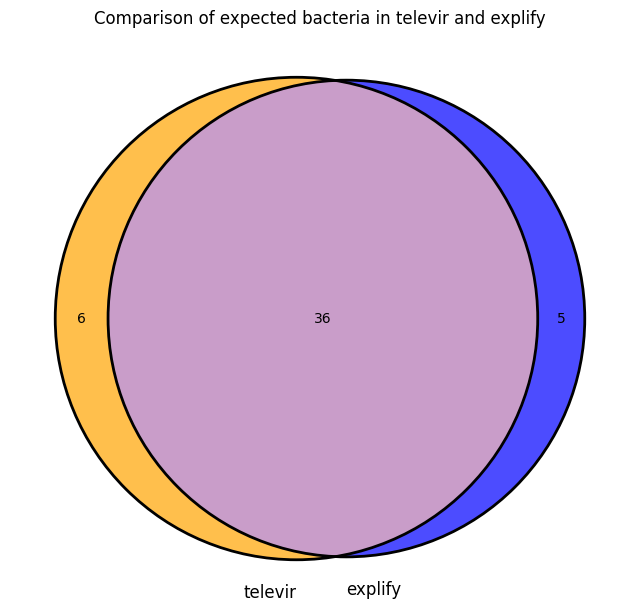

In [10]:

subsets= tuple(table_venn.expected.values[[1,2,3]])
names= ("televir", "explify")

## fig size
plt.figure(figsize=(8,8))
plt.title("Comparison of expected bacteria in televir and explify")
venn2(subsets=subsets, set_labels=names,
            set_colors=("orange",
                  "blue"),alpha=0.7)

venn2_circles(subsets= subsets)
plt.show()

In [11]:
analysis_panel[analysis_panel.televir_found == 0]

,Sample_ID,Expected_Bact,Sample_Nature,Explify_summary,explify_found,explify_false_positives,expected,TELEVIR_summary,televir_found,televir_false_positives,congruent_false_positives_count,congruent_false_positives,in_project_samples
10,Met_RPIP_388582_2023,Listeria monocytogenes,clinical,0/1,0,9,1,0/1,0,25,18,Pseudomonas;Pseudomonas;Pseudomonas;Pseudomona...,True
11,Met_RPIP_389094_2023,Listeria monocytogenes,clinical,0/1,0,8,1,0/1,0,23,21,Pseudomonas;Pseudomonas;Pseudomonas;Pseudomona...,True
14,Met_RPIP_412203_2023,Trichomonas vaginalis,clinical,0/1,0,4,1,0/1,0,17,1,Ureaplasma,True
15,Met_RPIP_412346_2023,Trichomonas vaginalis,clinical,0/1,0,4,1,0/1,0,18,1,Fusobacterium,True
15,Met_RPIP_412346_2023,Ureaplasma urealyticum,clinical,0/1,0,4,1,0/1,0,18,1,Fusobacterium,True
15,Met_RPIP_412346_2023,Mycoplasma hominis,clinical,0/1,0,4,1,0/1,0,18,1,Fusobacterium,True
15,Met_RPIP_412346_2023,Ureaplasma parvum,clinical,0/1,0,4,1,0/1,0,18,1,Fusobacterium,True
16,Met_RPIP_413222_2023,Neisseria gonorrhoeae,clinical,0/1,0,7,1,0/1,0,21,3,Fusobacterium;Bacteroides;Finegoldia,True
16,Met_RPIP_413222_2023,Ureplasma urealyticum,clinical,0/1,0,7,1,0/1,0,21,3,Fusobacterium;Bacteroides;Finegoldia,True
16,Met_RPIP_413222_2023,Mycoplasma hominis,clinical,0/1,0,7,1,0/1,0,21,3,Fusobacterium;Bacteroides;Finegoldia,True


In [12]:

sample_stats= analysis_panel[ref_panel.Expected_Bact != "Negative"]
sample_stats= sample_stats[sample_stats.in_project_samples == True]
sample_stats[["televir_found","expected"]].sum()




televir_found    42
expected         69
dtype: int64

In [13]:
culture_panel= analysis_panel[analysis_panel.Sample_Nature == "culture"]
sample_stats= culture_panel[culture_panel.Expected_Bact != "Negative"]
sample_stats= sample_stats[sample_stats.in_project_samples == True]
sample_stats[["explify_found","expected"]].sum()

explify_found    17
expected         17
dtype: int64

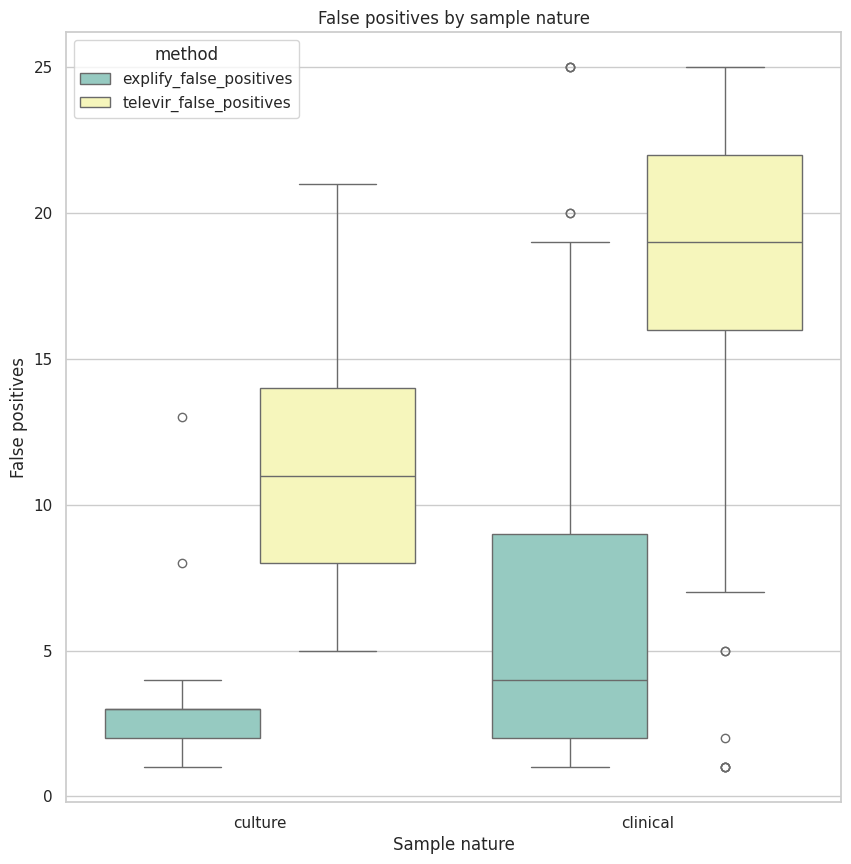

In [14]:
df_boxplot= analysis_panel[["explify_false_positives", "televir_false_positives", "Sample_Nature"]]
df_boxplot= pd.melt(df_boxplot, id_vars="Sample_Nature", var_name= "method")

# seaborn boxplot of false positives by sample nature for televir and explify, same plot

import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10,10))
sns.set_theme(style="whitegrid")

ax = sns.boxplot(x="Sample_Nature", y="value", hue="method",
                    data=df_boxplot, palette="Set3")

ax.set_title("False positives by sample nature")
ax.set_ylabel("False positives")
ax.set_xlabel("Sample nature")

plt.show()


In [15]:
culture_panel.head(20)

,Sample_ID,Expected_Bact,Sample_Nature,Explify_summary,explify_found,explify_false_positives,expected,TELEVIR_summary,televir_found,televir_false_positives,congruent_false_positives_count,congruent_false_positives,in_project_samples
0,Met_RPIP_189502_2023,Mycobacterium abscessus,culture,1/1,1,4,1,1/1,1,10,1,Pseudomonas,True
1,Met_RPIP_217675_2023,Mycobacterium avium complex,culture,1/1,1,2,1,1/1,1,5,0,,True
2,Met_RPIP_235296_2023,Mycobacterium simiae,culture,1/1,1,3,1,1/1,1,13,0,,True
3,Met_RPIP_278815_2023,Mycobacterium xenopi,culture,1/1,1,2,1,1/1,1,14,0,,True
4,Met_RPIP_286185_2023,Mycobacterium malmoense,culture,1/1,1,3,1,1/1,1,8,1,Pseudomonas,True
5,Met_RPIP_307582_2023,Mycobacterium gordonae,culture,1/1,1,2,1,1/1,1,5,0,,True
6,Met_RPIP_339439_2023,Mycobacterium chelonae,culture,1/1,1,8,1,1/1,1,9,2,Pseudomonas;Actinomyces,True
7,Met_RPIP_345707_2023,Mycobacterium fortuitum,culture,1/1,1,1,1,1/1,1,13,0,,True
8,Met_RPIP_352100_2023,Mycobacterium szulgai,culture,1/1,1,2,1,1/1,1,14,1,Pseudomonas,True
22,Met_RPIP_478672_2023,Mycobacterium kansasii,culture,1/1,1,2,1,1/1,1,11,1,Pseudomonas,True


In [16]:
culture_panel.to_csv("analysis/cultures_summary.tsv", sep="\t", index=False)

In [17]:


for sample in culture_panel.Sample_ID.values:

    sample= row["Sample"]
    description= row["TELEVir Description"]
    sample_safe= sample.replace("-", "_")
    samples_names_consider= [
        sample, sample_safe
    ]
    df= ref_panel[ref_panel["Sample_Name"].isin(samples_names_consider)]

    counts= 0
    if ";" in description:
        descriptions= description.split(";")
    else:
        descriptions= [description]

    descriptions= {
        desc: 0 for desc in descriptions
    }
    false_positives= {}

    for desc in df["TELEVir Description"].values:
        species_found= False

        for path in descriptions.keys():

            if type(desc) == float:
                continue
            if species_in_description(path, desc):


                descriptions[path] = 1
                species_found= True
                break
                
        if species_found == False:
            false_positives[desc] = 1
                

    counts_found= f"{sum(descriptions.values())}/{len(descriptions)}"



    row["TELEVIR_summary"]= counts_found
    row["televir_found"]= sum(descriptions.values())
    row["televir_false_positives"]= sum(false_positives.values())
    #row["televir_expected"]= len(descriptions)


NameError: name 'row' is not defined